### Objective: To analyze YouTube channel statistics in order to identify key factors that contribute to a channel’s success, measured by the number of trending videos and subscriber count. 

#### Table of contents
* Load the dataset
* Data structure
* Data analysi

#### Data Structure
* Channel dataset contains 137 rows and 9 features

#### The Following Questions Are of My Interest:
* What is the relationship between a channel’s subscriber count and the number of trending videos?
* How does the upload rate (frequency of video uploads) influence the number of trending videos?
* Can the number of trending videos be predicted by a channel's subscriber count and upload rate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
from scipy import stats
from wordcloud import WordCloud
from datetime import datetime, timezone

## Load the dataset

In [2]:
df_video = pd.read_csv('D:\Project_DA\Youtube Api\TrendingVideo_YTdata.csv', index_col = 0)
df_channels = pd.read_csv('D:\Project_DA\Youtube Api\ChannelInfo_TrendingVideo.csv', index_col = 0)

In [3]:
df_channels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 0 to 136
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   channelId              137 non-null    object
 1   channel_publishedAt    137 non-null    object
 2   channelTitle           137 non-null    object
 3   channel_viewCount      137 non-null    int64 
 4   subscriberCount        137 non-null    int64 
 5   hiddenSubscriberCount  137 non-null    bool  
 6   videoCount             137 non-null    int64 
 7   keywords               137 non-null    object
 8   defaultLang            9 non-null      object
dtypes: bool(1), int64(3), object(5)
memory usage: 9.8+ KB


## Relationship Between Subscriber Count and Channel Success:

#### Whether channels with higher subscriber counts are more likely to produce trending videos??

In [4]:
#groupy channel id and see how many trending videos of each channel id is?
trending_videos_count = df_video.groupby('channelId').size().reset_index(name = 'trending_videos_count')
#then check their subscriber count by merging with the df_channels dataframe
df_channel_trend = pd.merge(df_channels,trending_videos_count, on= 'channelId')


In [5]:
correlation = df_channel_trend[['subscriberCount','trending_videos_count']].corr(method = 'spearman')
print("Correlation between subscriber count and trending videos:\n\n", correlation)

Correlation between subscriber count and trending videos:

                        subscriberCount  trending_videos_count
subscriberCount               1.000000               0.467572
trending_videos_count         0.467572               1.000000


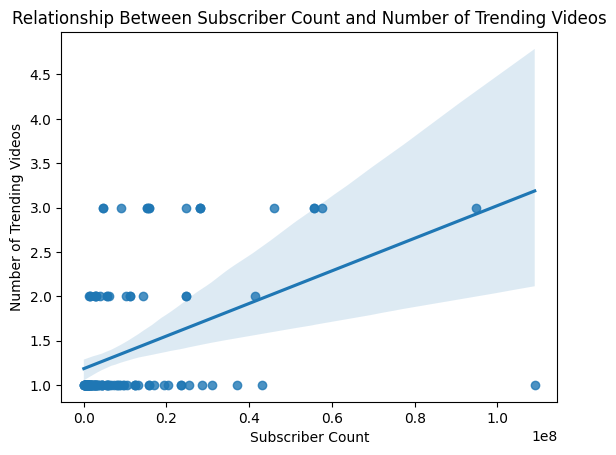

In [6]:
sns.regplot(x='subscriberCount', y='trending_videos_count', data=df_channel_trend)
plt.title('Relationship Between Subscriber Count and Number of Trending Videos')
plt.xlabel('Subscriber Count')
plt.ylabel('Number of Trending Videos')
plt.show()

#### This suggests that channels with more subscribers tend to have more trending videos but have a moderate correlation.

## Relationship between upload rate and trending videos/subscriber count

In [7]:
df_channel_trend.columns

Index(['channelId', 'channel_publishedAt', 'channelTitle', 'channel_viewCount',
       'subscriberCount', 'hiddenSubscriberCount', 'videoCount', 'keywords',
       'defaultLang', 'trending_videos_count'],
      dtype='object')

In [8]:
df_channel_trend['channel_publishedAt'] =  pd.to_datetime(df_channel_trend['channel_publishedAt'], format='ISO8601')

In [9]:
# Convert datetime.now() to timezone-aware
current_time = datetime.now(timezone.utc)

In [10]:
df_channel_trend['channel_age']= (current_time- df_channel_trend['channel_publishedAt']).dt.days/365.25

In [11]:
# Calculate the upload rate
df_channel_trend['upload_rate'] = df_channel_trend['videoCount'] / df_channel_trend['channel_age']

In [20]:
correlation_2 = df_channel_trend[['subscriberCount','trending_videos_count','upload_rate', 'channel_age']].corr(method = 'spearman')
print("Correlation between subscriber count and trending videos and upload rate:\n\n", correlation_2)

Correlation between subscriber count and trending videos and upload rate:

                        subscriberCount  trending_videos_count  upload_rate  \
subscriberCount               1.000000               0.467572     0.548538   
trending_videos_count         0.467572               1.000000     0.553119   
upload_rate                   0.548538               0.553119     1.000000   
channel_age                   0.348945               0.153890     0.177549   

                       channel_age  
subscriberCount           0.348945  
trending_videos_count     0.153890  
upload_rate               0.177549  
channel_age               1.000000  


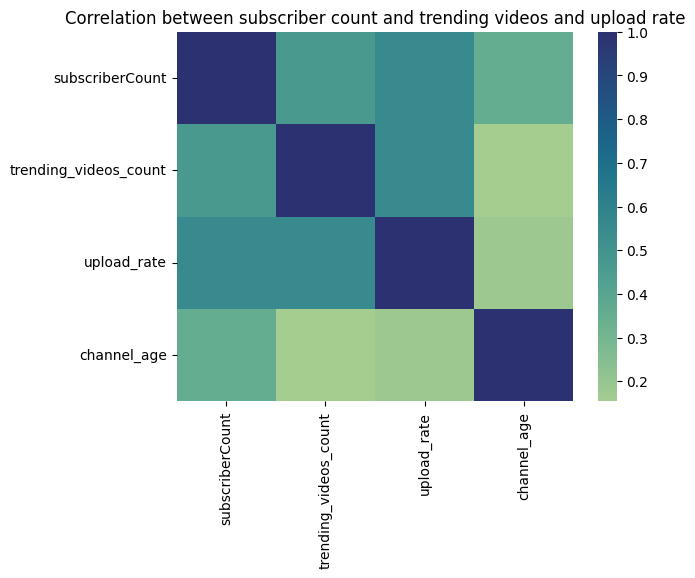

In [21]:
#heatmap
sns.heatmap(correlation_2, cmap= 'crest')
plt.title('Correlation between subscriber count and trending videos and upload rate')
plt.show()

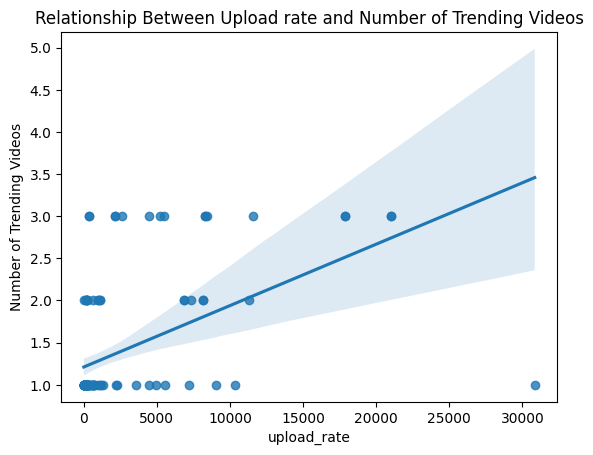

In [14]:
sns.regplot(x='upload_rate', y='trending_videos_count', data=df_channel_trend)
plt.title('Relationship Between Upload rate and Number of Trending Videos')
plt.xlabel('upload_rate')
plt.ylabel('Number of Trending Videos')
plt.show()

**This suggests that higher the upload rate of the channel more is the chance of the channel having trending videos**

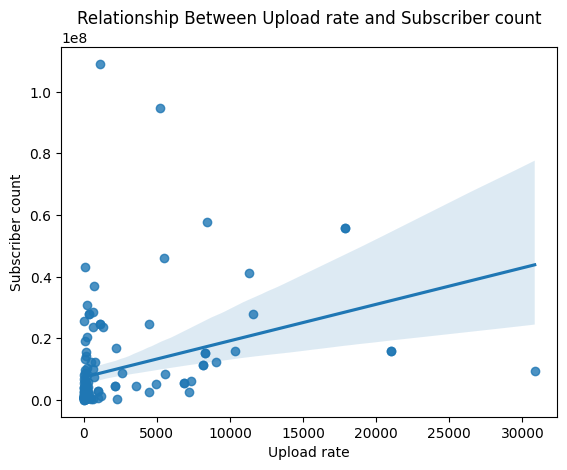

In [15]:
sns.regplot(x='upload_rate', y='subscriberCount', data=df_channel_trend)
plt.title('Relationship Between Upload rate and Subscriber count')
plt.ylabel('Subscriber count')
plt.xlabel('Upload rate')
plt.show()

**This suggests that higher upload rate tends to attract more subscriber count**

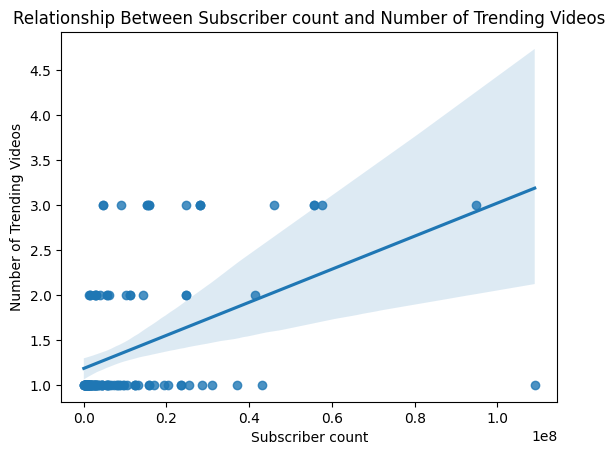

In [23]:
sns.regplot(x='subscriberCount', y='trending_videos_count', data=df_channel_trend)
plt.title('Relationship Between Subscriber count and Number of Trending Videos')
plt.xlabel('Subscriber count')
plt.ylabel('Number of Trending Videos')
plt.show()

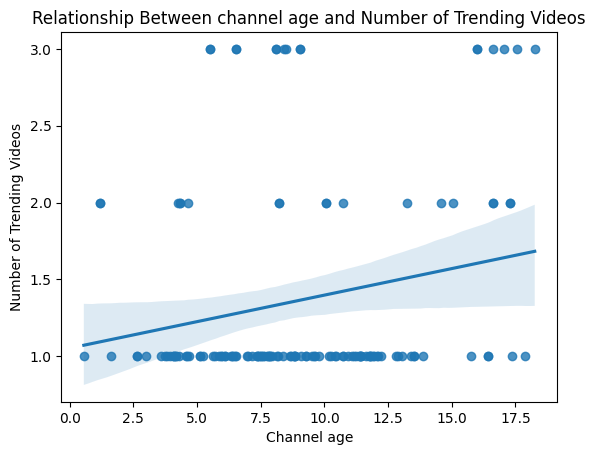

In [22]:
sns.regplot(x='channel_age', y='trending_videos_count', data=df_channel_trend)
plt.title('Relationship Between channel age and Number of Trending Videos')
plt.xlabel('Channel age')
plt.ylabel('Number of Trending Videos')
plt.show()

**No correlation**

### Fiting a linear regression model to predict the 'trending videos count' using the upload rate and subscriber count:

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
features = df_channel_trend[['subscriberCount', 'upload_rate', 'channel_age']]
Y = df_channel_trend['trending_videos_count']

In [26]:
lm = LinearRegression()
lm.fit(features, Y)
r_squared_value= lm.score(features, Y)
coefficients = lm.coef_
intercept = lm.intercept_

print("R suared value:", r_squared_value)
print("Coefficients:", coefficients)
print("Intercept:", intercept)

R suared value: 0.3414569368972815
Coefficients: [1.19925416e-08 5.72320143e-05 1.11637335e-02]
Intercept: 1.0244333175741462


#### Improve the model by standardising the features and introducing the polynomial features

In [27]:
Input=[('scale',StandardScaler()),('polynomial', PolynomialFeatures(include_bias=False)),('model',LinearRegression())]
pipe= Pipeline(Input)
pipe.fit(features, Y)
ypipe= pipe.predict(features)
r2_score(Y, ypipe)

0.4909583783029371

#### An R-squared value of 0.3414 means that approximately 34.14% of the variance in 'trending_videos_count' can be explained by the independent variables 'subscriberCount' and 'upload_rate'
* This is a moderate level of explanatory power. It suggests that while our model does capture some of the variability in the number of trending videos, a significant portion of the variability is explained by other factors not included in our model.